In [1]:
%matplotlib inline


# Combine predictors using stacking


.. currentmodule:: sklearn

Stacking refers to a method to blend estimators. In this strategy, some
estimators are individually fitted on some training data while a final
estimator is trained using the stacked predictions of these base estimators.

In this example, we illustrate the use case in which different regressors are
stacked together and a final linear penalized regressor is used to output the
prediction. We compare the performance of each individual regressor with the
stacking strategy. Stacking slightly improves the overall performance.


In [2]:
print(__doc__)

# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
#          Maria Telenczuk    <https://github.com/maikia>
# License: BSD 3 clause

Automatically created module for IPython interactive environment


Download the dataset
##############################################################################

 We will use `Ames Housing`_ dataset which was first compiled by Dean De Cock
 and became better known after it was used in Kaggle challenge. It is a set
 of 1460 residential homes in Ames, Iowa, each described by 80 features. We
 will use it to predict the final logarithmic price of the houses. In this
 example we will use only 20 most interesting features chosen using
 GradientBoostingRegressor() and limit number of entries (here we won't go
 into the details on how to select the most interesting features).

 The Ames housing dataset is not shipped with scikit-learn and therefore we
 will fetch it from `OpenML`_.




In [3]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle


def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True)
    X = df.data
    y = df.target

    features = ['YrSold', 'HeatingQC', 'Street', 'YearRemodAdd', 'Heating',
                'MasVnrType', 'BsmtUnfSF', 'Foundation', 'MasVnrArea',
                'MSSubClass', 'ExterQual', 'Condition2', 'GarageCars',
                'GarageType', 'OverallQual', 'TotalBsmtSF', 'BsmtFinSF1',
                'HouseStyle', 'MiscFeature', 'MoSold']

    X = X[features]
    X, y = shuffle(X, y, random_state=0)

    X = X[:600]
    y = y[:600]
    return X, np.log(y)


X, y = load_ames_housing()

/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Make pipeline to preprocess the data
##############################################################################

 Before we can use Ames dataset we still need to do some preprocessing.
 First, the dataset has many missing values. To impute them, we will exchange
 categorical missing values with the new category 'missing' while the
 numerical missing values with the 'mean' of the column. We will also encode
 the categories with either :class:`sklearn.preprocessing.OneHotEncoder
 <sklearn.preprocessing.OneHotEncoder>` or
 :class:`sklearn.preprocessing.OrdinalEncoder
 <sklearn.preprocessing.OrdinalEncoder>` depending for which type of model we
 will use them (linear or non-linear model). To falicitate this preprocessing
 we will make two pipelines.
 You can skip this section if your data is ready to use and does
 not need preprocessing



In [4]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


cat_cols = X.columns[X.dtypes == 'O']
num_cols = X.columns[X.dtypes == 'float64']

categories = [
    X[column].unique() for column in X[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa

cat_proc_nlin = make_pipeline(
    SimpleImputer(missing_values=None, strategy='constant',
                  fill_value='missing'),
    OrdinalEncoder(categories=categories)
    )

num_proc_nlin = make_pipeline(SimpleImputer(strategy='mean'))

cat_proc_lin = make_pipeline(
    SimpleImputer(missing_values=None,
                  strategy='constant',
                  fill_value='missing'),
    OneHotEncoder(categories=categories)
)

num_proc_lin = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

# transformation to use for non-linear estimators
processor_nlin = make_column_transformer(
    (cat_proc_nlin, cat_cols),
    (num_proc_nlin, num_cols),
    remainder='passthrough')

# transformation to use for linear estimators
processor_lin = make_column_transformer(
    (cat_proc_lin, cat_cols),
    (num_proc_lin, num_cols),
    remainder='passthrough')

Stack of predictors on a single data set
##############################################################################

 It is sometimes tedious to find the model which will best perform on a given
 dataset. Stacking provide an alternative by combining the outputs of several
 learners, without the need to choose a model specifically. The performance of
 stacking is usually close to the best model and sometimes it can outperform
 the prediction performance of each individual model.

 Here, we combine 3 learners (linear and non-linear) and use a ridge regressor
 to combine their outputs together.

 Note: although we will make new pipelines with the processors which we wrote
 in the previous section for the 3 learners, the final estimator RidgeCV()
 does not need preprocessing of the data as it will be fed with the already
 preprocessed output from the 3 learners.



In [5]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV


lasso_pipeline = make_pipeline(processor_lin,
                               LassoCV())

rf_pipeline = make_pipeline(processor_nlin,
                            RandomForestRegressor(random_state=42))

gradient_pipeline = make_pipeline(
    processor_nlin,
    HistGradientBoostingRegressor(random_state=0))

estimators = [('Random Forest', rf_pipeline),
              ('Lasso', lasso_pipeline),
              ('Gradient Boosting', gradient_pipeline)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

Measure and plot the results
##############################################################################

 Now we can use Ames Housing dataset to make the predictions. We check the
 performance of each individual predictor as well as of the stack of the
 regressors.

 The function ``plot_regression_results`` is used to plot the predicted and
 true targets.



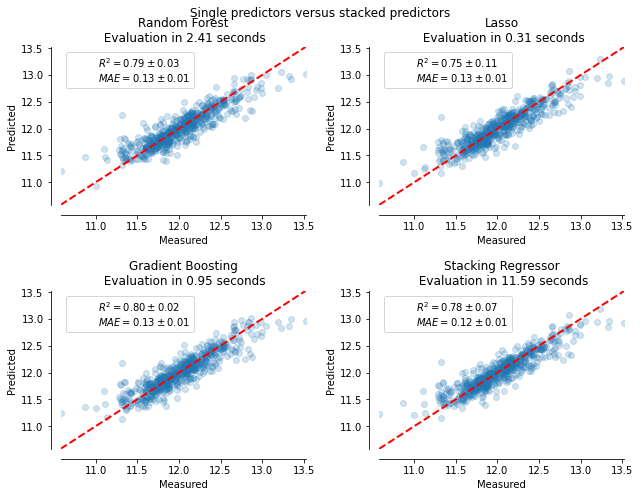

In [6]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The stacked regressor will combine the strengths of the different regressors.
However, we also see that training the stacked regressor is much more
computationally expensive.

